In [1]:
import pandas as pd
 
file_path = r"C:\Users\User\Downloads\datamining_clean_dataset.csv"
df = pd.read_csv(file_path)

# Check the basic info
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())


Dataset shape: (31965016, 9)
   userId  movieId  rating  timestamp             datetime  \
0       1       17     4.0  944249077  1999-12-03 19:24:37   
1       1       25     1.0  944250228  1999-12-03 19:43:48   
2       1       29     2.0  943230976  1999-11-22 00:36:16   
3       1       30     5.0  944249077  1999-12-03 19:24:37   
4       1       32     5.0  943228858  1999-11-22 00:00:58   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres    year  \
0                           Drama|Romance  1995.0   
1                           Drama|Romance  1995.0   
2  Adventure|Drama|Fantasy|Mystery|Sci-Fi  1995.0   
3                             Crime|Drama  1995.0

In [3]:
min_user_ratings = 50
min_movie_ratings = 50

user_counts = df['userId'].value_counts()
movie_counts = df['movieId'].value_counts()

filtered_df = df[
    (df['userId'].isin(user_counts[user_counts >= min_user_ratings].index)) &
    (df['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index))
]

print("Original shape:", df.shape)
print("After filtering:", filtered_df.shape)

Original shape: (31965016, 9)
After filtering: (29176648, 9)


In [5]:
#  Select top 1000 users and top 1000 movies
top_users = filtered_df['userId'].value_counts().index[:1000]
top_movies = filtered_df['movieId'].value_counts().index[:1000]

subset_df = filtered_df[
    (filtered_df['userId'].isin(top_users)) &
    (filtered_df['movieId'].isin(top_movies))
]

print("Subset shape:", subset_df.shape)


Subset shape: (658516, 9)


In [7]:
# Create User–Item Matrix
user_item_matrix = subset_df.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
).fillna(0)

print("User-Item Matrix shape:", user_item_matrix.shape)


User-Item Matrix shape: (1000, 1000)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_item_matrix.index, 
    columns=user_item_matrix.index
)

# Example: top 5 similar users to user 1
sample_user = user_item_matrix.index[0]
similar_users = user_similarity_df[sample_user].sort_values(ascending=False)[1:6]

print(f"Top similar users to {sample_user}:")
print(similar_users)


Top similar users to 28:
userId
175325    0.928221
9085      0.919174
15875     0.914316
86167     0.913464
162621    0.910950
Name: 28, dtype: float64


In [11]:
# Compute cosine similarity between movies
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_matrix.columns,
    columns=user_item_matrix.columns
)

# Example: top 5 similar movies to the first one
sample_movie = user_item_matrix.columns[0]
similar_movies = item_similarity_df[sample_movie].sort_values(ascending=False)[1:6]

print(f"Top similar movies to {sample_movie}:")
print(similar_movies)


Top similar movies to 1:
movieId
3114    0.941909
1270    0.941555
1198    0.940614
480     0.935342
260     0.934461
Name: 1, dtype: float64


In [13]:
def recommend_movies(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return "User not found in dataset"
    
    # Get ratings of this user
    user_ratings = user_item_matrix.loc[user_id]
    
    # Movies not rated yet
    unrated_movies = user_ratings[user_ratings == 0].index
    
    scores = {}
    for movie in unrated_movies:
        # Movies the user already rated
        rated_movies = user_ratings[user_ratings > 0].index
        
        # Similarity with those movies
        sim_scores = item_similarity_df.loc[movie, rated_movies]
        rating_scores = user_ratings[rated_movies]
        
        # Weighted score
        score = (sim_scores * rating_scores).sum() / (sim_scores.sum() + 1e-9)
        scores[movie] = score
    
    # Pick top N
    top_movies = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Map movieId → title
    recs = []
    for mid, sc in top_movies:
        title = df.loc[df['movieId'] == mid, 'title'].values
        if len(title) > 0:
            recs.append(title[0])
        else:
            recs.append(mid)
    
    return recs

# Example: recommend movies for userId=28
print("Recommended movies for user 28:")
print(recommend_movies(28, top_n=5))


Recommended movies for user 28:
['Manhattan (1979)', 'Lives of Others, The (Das leben der Anderen) (2006)', 'Hoop Dreams (1994)', 'Delicatessen (1991)', 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)']


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Take unique movies (avoid duplicates by movieId)
unique_movies = df.drop_duplicates(subset="movieId")

# Sample 2000 movies for speed (optional, remove if you want full dataset)
unique_movies = unique_movies.sample(2000, random_state=42)

# TF-IDF on genres
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(unique_movies['genres'].fillna(""))

# Compute cosine similarity between movies
content_similarity = cosine_similarity(tfidf_matrix)

print("Content-based similarity matrix shape:", content_similarity.shape)


Content-based similarity matrix shape: (2000, 2000)


In [21]:
def recommend_movies_content(movie_title, top_n=5):
    # Case-insensitive search for the movie
    matches = unique_movies[unique_movies['title'].str.lower() == movie_title.lower()]
    
    if matches.empty:
        # Try partial match (contains)
        matches = unique_movies[unique_movies['title'].str.lower().str.contains(movie_title.lower())]
        
    if matches.empty:
        return f"Movie '{movie_title}' not found in dataset"
    
    # Take the first matched movie
    idx = matches.index[0]
    
    # get similarity scores for this movie
    sim_scores = list(enumerate(content_similarity[idx]))
    
    # sort movies by similarity score (highest first), skip the movie itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # get movie titles
    movie_indices = [i[0] for i in sim_scores]
    return unique_movies.iloc[movie_indices]['title'].tolist()

# Example
print("Movies similar to Toy Story:")
print(recommend_movies_content("Toy Story"))


Movies similar to Toy Story:
Movie 'Toy Story' not found in dataset


In [23]:
unique_movies[unique_movies['title'].str.contains("Toy Story", case=False, na=False)][['movieId', 'title']].head(10)


,movieId,title


In [25]:
unique_movies[unique_movies['title'].str.contains("Toy", case=False, na=False)][['movieId','title']].head(20)


,movieId,title
7391158,83439,Toys in the Attic (1963)
2298585,267938,A Toytown Tale (1931)


In [31]:
unique_movies = df.drop_duplicates(subset="movieId")


In [35]:
# Take a sample of unique movies with genres (avoid missing data)
unique_movies = df[['movieId', 'title', 'genres']].drop_duplicates(subset="movieId")
unique_movies = unique_movies[unique_movies['genres'].notnull()]

# Sample smaller subset for memory safety
unique_movies = unique_movies.sample(3000, random_state=42)

# TF-IDF on genres
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(unique_movies['genres'])

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
content_similarity = cosine_similarity(tfidf_matrix)

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Content-based similarity matrix shape:", content_similarity.shape)


TF-IDF matrix shape: (3000, 23)
Content-based similarity matrix shape: (3000, 3000)


In [37]:
print(unique_movies[['title']].sample(10))


                                       title
9614685                    Wolf Manor (2022)
932062                   Animalympics (1980)
2274                     Nightcrawler (2014)
1223149                  Poshter Boyz (2014)
3941690          Kyaa Kool Hain Hum 3 (2016)
8133866             Black Cat Mansion (1958)
238526                       Rio Rita (1942)
3270395                    Exit Speed (2008)
489972    The Last House in the Woods (2007)
15973443         Pro Dia Nascer Feliz (2006)


In [2]:
def recommend_similar_movies(title, top_n=5):
    # Try to match title (case-insensitive)
    matches = unique_movies[unique_movies['title'].str.lower() == title.lower()]
    
    if matches.empty:
        # Try partial match if exact title not found
        matches = unique_movies[unique_movies['title'].str.lower().str.contains(title.lower())]
    
    if matches.empty:
        return f"Movie '{title}' not found in dataset."
    
    idx = matches.index[0]  # index in unique_movies
    sim_scores = list(enumerate(content_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    movie_indices = [i[0] for i in sim_scores]
    return unique_movies.iloc[movie_indices]['title'].tolist()


In [43]:
print("Movies similar to 'Nightcrawler (2014)':")
print(recommend_similar_movies("Nightcrawler (2014)"))


Movies similar to 'Nightcrawler (2014)':
['Intimate Lighting (Intimni osvetleni) (1965)', 'The Happiness of the World (2016)', 'Saare Jahaan Se Mehnga (2013)', 'Amy (1998)', 'Testosterone (2003)']


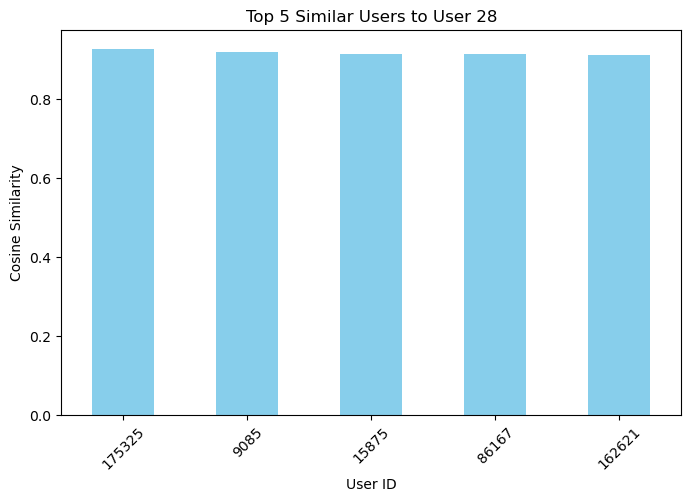

In [45]:
import matplotlib.pyplot as plt

# Get top 5 similar users to user 28
similar_users = user_similarity_df.loc[28].sort_values(ascending=False)[1:6]

plt.figure(figsize=(8,5))
similar_users.plot(kind='bar', color='skyblue')
plt.title('Top 5 Similar Users to User 28')
plt.xlabel('User ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.show()


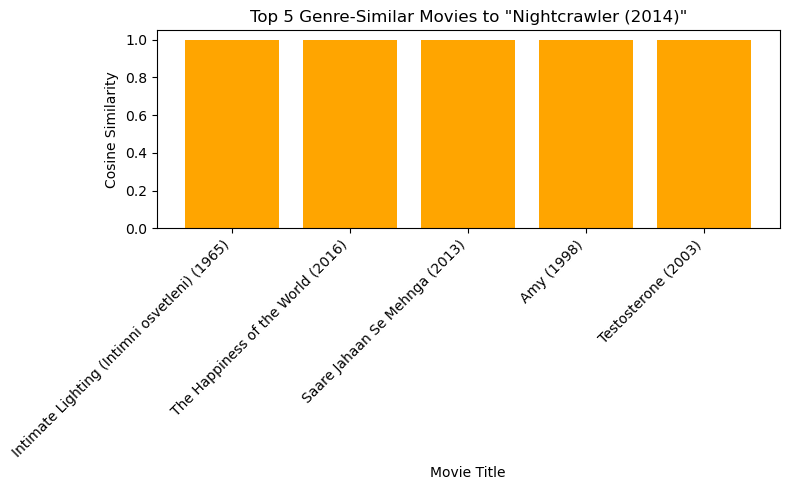

In [47]:
# Find index of 'Nightcrawler (2014)' in unique_movies
movie_title = "Nightcrawler (2014)"
matches = unique_movies[unique_movies['title'].str.lower() == movie_title.lower()]

if not matches.empty:
    idx = matches.index[0]
    sim_scores = list(enumerate(content_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    
    indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    titles = unique_movies.iloc[indices]['title']

    plt.figure(figsize=(8,5))
    plt.bar(titles, scores, color='orange')
    plt.title(f'Top 5 Genre-Similar Movies to "{movie_title}"')
    plt.xlabel('Movie Title')
    plt.ylabel('Cosine Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print(f'Movie "{movie_title}" not found in unique_movies.')

